d:\OneDrive - GS Retail Co., Ltd\문서\munchooRG\munchoovm\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_45844\1483938837.py:209: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
d:\OneDrive - GS Retail Co., Ltd\문서\munchooRG\munchoovm\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128178 (\N{HEAVY DOLLAR SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)
d:\OneDrive - GS Retail Co., Ltd\문서\munchooRG\munchoovm\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


✅ 예측 완료 (잔당판매가: 시즌성만 반영): retail_forecast_final_no_trend_price.xlsx


d:\OneDrive - GS Retail Co., Ltd\문서\munchooRG\munchoovm\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)
d:\OneDrive - GS Retail Co., Ltd\문서\munchooRG\munchoovm\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


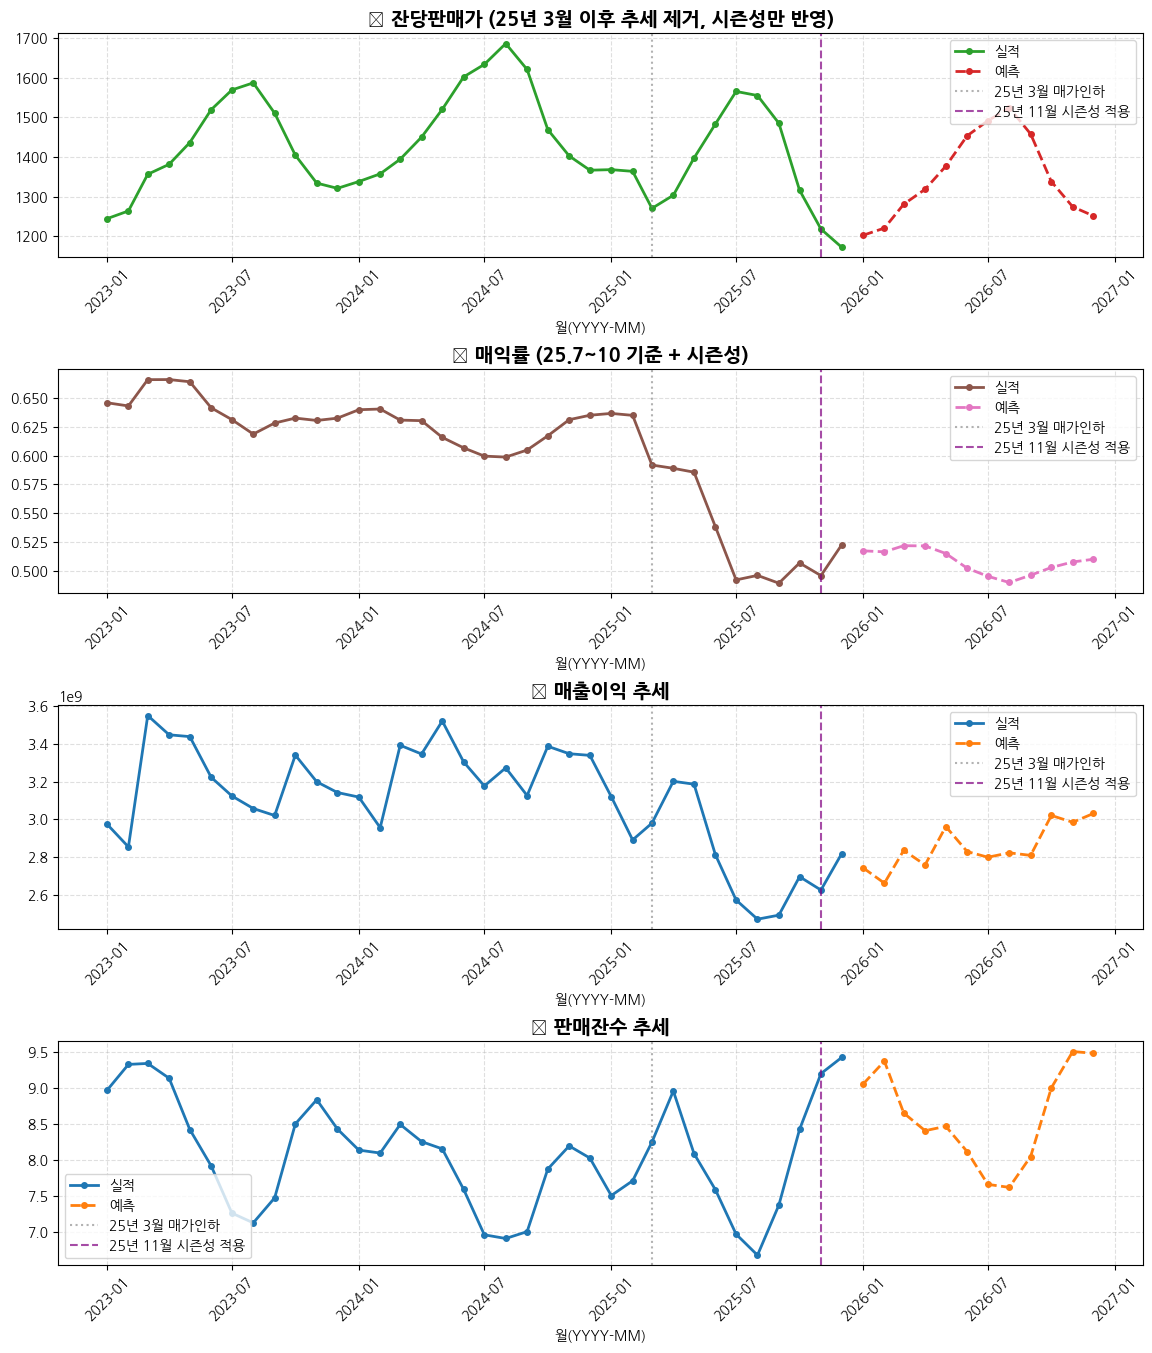

In [19]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# =========================================
# 🧩 한글 폰트 설정
# =========================================
font_candidates = ["batang", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "Noto Sans KR"]
available = {f.name for f in fm.fontManager.ttflist}
for name in font_candidates:
    if name in available:
        mpl.rcParams["font.family"] = name
        break
mpl.rcParams["axes.unicode_minus"] = False

# font_candidates = ["Pretendard"]
# available = {f.name for f in fm.fontManager.ttflist}
# for name in font_candidates:
#     if name in available:
#         mpl.rcParams["font.family"] = name
#         break
# mpl.rcParams["axes.unicode_minus"] = False


# # =========================================
# 1️⃣ 엑셀 불러오기
# =========================================
file_path = "retail_data.xlsx"  # ⚠️ 실제 경로로 수정
df = pd.read_excel(file_path)

required_cols = ["yymm", "판매수량", "매출액", "매출이익", "영업일수"]
if not all(col in df.columns for col in required_cols):
    raise ValueError(f"필수 컬럼 {required_cols} 이(가) 누락됨")



def yymm_to_date(yymm):
    y, m = divmod(int(yymm), 100)
    return pd.Timestamp(year=y, month=m, day=1)

df["date"] = df["yymm"].apply(yymm_to_date)
df = df.set_index("date").asfreq("MS").sort_index()

# =========================================
# 2️⃣ 파생지표 계산
# =========================================
df["판매잔수"]   = df["판매수량"] / df["영업일수"]
df["잔당판매가"] = df["매출액"] / df["판매수량"]
df["매익률"]     = df["매출이익"] / df["매출액"]
df["일매출"]     = df["매출액"] / df["영업일수"]

# =========================================
# 3️⃣ ETS 예측 함수 (판매잔수·영업일수만)
# =========================================
def forecast_ets(series, steps, seasonal_periods=12):
    try:
        model = ExponentialSmoothing(
            series.astype(float),
            trend="add",
            seasonal="add",
            seasonal_periods=seasonal_periods,
            initialization_method="estimated"
        ).fit(optimized=True)
        return model.forecast(steps)
    except Exception:
        return pd.Series(
            [series.tail(12).mean()] * steps,
            index=pd.date_range(series.index[-1] + pd.offsets.MonthBegin(1),
                                periods=steps, freq="MS")
        )

# =========================================
# 4️⃣ 예측 기간 생성
# =========================================
forecast_end = pd.Timestamp("2026-12-01")
future_index = pd.date_range(df.index[-1] + pd.offsets.MonthBegin(1),
                             forecast_end, freq="MS")
steps = len(future_index)

# 판매잔수, 영업일수 예측
fcst_days = forecast_ets(df["영업일수"], steps)
fcst_cups = forecast_ets(df["판매잔수"], steps)

# =========================================
# 영업일수 트렌드 낮추기 (예: 예측 기간 전체에 걸쳐 총 12% 감소)
# 필요 시 days_trend_reduce 값을 조정하세요.
# =========================================
days_trend_reduce = 0.02  # 전체 감소 비율 (0.12 = 12%)
months = np.arange(1, steps + 1)
reduction = 1 - (months / steps) * days_trend_reduce
fcst_days = fcst_days * reduction

# =========================================
# 5️⃣ 잔당판매가: 25년 3월 이후는 추세 제거, 시즌성만 반영
# =========================================
# 기준 레벨: 25년 3~12월 평균 잔당판매가
mask_25_mar_dec = (df.index >= "2025-03-01") & (df.index <= "2025-12-31")
base_price = df.loc[mask_25_mar_dec, "잔당판매가"].mean()

# 월별 시즌성: 23~24년 월별 평균
season_src = df.loc[(df.index >= "2023-01-01") & (df.index <= "2024-12-31")].copy()
season_src["month"] = season_src.index.month
month_avg_price = season_src.groupby("month")["잔당판매가"].mean()

# 정규화: 3~12월 평균 = 1
norm_price = month_avg_price.loc[[3,4,5,6,7,8,9,10,11,12]].mean()
season_factor_price = month_avg_price / norm_price

# 25.11 ~ 26.12 구간 적용
apply_months = future_index.month
price_season = apply_months.map(season_factor_price)
fcst_price = pd.Series(base_price * price_season.values, index=future_index)

# =========================================
# 6️⃣ 매익률: 25.7~10 평균 × 23~24 시즌성
# =========================================
mask_25_7_10 = (df.index >= "2025-07-01") & (df.index <= "2025-10-31")
base_margin = df.loc[mask_25_7_10, "매익률"].mean()

season_src_margin = df.loc[(df.index >= "2023-01-01") & (df.index <= "2024-12-31")].copy()
season_src_margin["month"] = season_src_margin.index.month
month_avg_margin = season_src_margin.groupby("month")["매익률"].mean()

norm_margin = month_avg_margin.loc[[7,8,9,10]].mean()
season_factor_margin = month_avg_margin / norm_margin

apply_months_margin = future_index.month
margin_season = apply_months_margin.map(season_factor_margin)
fcst_margin = pd.Series(base_margin * margin_season.values, index=future_index)

# =========================================
# 7️⃣ 예측 데이터프레임 구성
# =========================================
df_fcst = pd.DataFrame(index=future_index)
df_fcst["영업일수"]   = fcst_days
df_fcst["판매잔수"]   = fcst_cups
df_fcst["잔당판매가"] = fcst_price
df_fcst["매익률"]     = fcst_margin

# =========================================
# 8️⃣ 시나리오 보정 (판매잔수만)
# =========================================
mask_25_nov_dec = (df_fcst.index >= "2025-11-01") & (df_fcst.index <= "2025-12-01")
df_fcst.loc[mask_25_nov_dec, "판매잔수"] *= 1.00

mask_26_mar_dec = (df_fcst.index >= "2026-03-01") & (df_fcst.index <= "2026-12-01")
df_fcst.loc[mask_26_mar_dec, "판매잔수"] *= 0.88

mask_26_apr = (df_fcst.index == "2026-04-01")
df_fcst.loc[mask_26_apr, "판매잔수"] *= 0.95

# =========================================
# 9️⃣ 파생지표 계산
# =========================================
df_fcst["판매수량"] = df_fcst["판매잔수"] * df_fcst["영업일수"]
df_fcst["매출액"]   = df_fcst["판매수량"] * df_fcst["잔당판매가"]
df_fcst["매출이익"] = df_fcst["매출액"] * df_fcst["매익률"]
df_fcst["일매출"]   = df_fcst["매출액"] / df_fcst["영업일수"]

# =========================================
# 🔟 통합 및 저장
# =========================================
df["구분"] = "actual"
df_fcst["구분"] = "forecast"

df_all = pd.concat([df, df_fcst])
df_all["yymm"] = df_all.index.year * 100 + df_all.index.month
df_all = df_all[[
    "yymm", "판매잔수", "영업일수", "판매수량",
    "잔당판매가", "매출액", "매출이익", "매익률",
    "일매출", "구분"
]]

out_path = "retail_forecast_final_no_trend_price.xlsx"
df_all.to_excel(out_path, index=False)
print(f"✅ 예측 완료 (잔당판매가: 시즌성만 반영): {out_path}")

# =========================================
# 11️⃣ 시각화
# =========================================
plt.style.use("seaborn-v0_8-muted")
fig, axes = plt.subplots(4, 1, figsize=(14, 16), gridspec_kw={'hspace': 0.5})

def plot(ax, actual, forecast, col, title, c1, c2):
    ax.plot(actual.index, actual[col], 'o-', color=c1, label="실적", linewidth=2, markersize=4)
    ax.plot(forecast.index, forecast[col], 'o--', color=c2, label="예측", linewidth=2, markersize=4)
    ax.axvline(pd.Timestamp("2025-03-01"), color="gray", linestyle=":", alpha=0.6, label="25년 3월 매가인하")
    ax.axvline(pd.Timestamp("2025-11-01"), color="purple", linestyle="--", alpha=0.7, label="25년 11월 시즌성 적용")
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend()



plot(axes[0], df, df_fcst, "잔당판매가", "💲 잔당판매가 (25년 3월 이후 추세 제거, 시즌성만 반영)", "#2ca02c", "#d62728")
plot(axes[1], df, df_fcst, "매익률", "📉 매익률 (25.7~10 기준 + 시즌성)", "#8c564b", "#e377c2")
plot(axes[2], df, df_fcst, "매출이익", "💵 매출이익 추세", "#1f77b4", "#ff7f0e")
plot(axes[3], df, df_fcst, "판매잔수", "📊 판매잔수 추세", "#1f77b4", "#ff7f0e")


for ax in axes:
    ax.set_xlabel("월(YYYY-MM)")
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m"))

plt.tight_layout()
plt.show()
